# Overview
This code assumes that you already have your dimensionally-reduced UKBB data. It is meant primarily to organize your datasets and create visualizations and carry out statistical tests.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import gzip
import numpy as np
import os
import phate
import scipy
import time
import matplotlib
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd

from collections import defaultdict
import itertools
from scipy.stats import ttest_ind

# Interactive HTML tools
from ipywidgets import interact
import bokeh
import bokeh.io
from bokeh.plotting import figure, show, save, output_notebook, output_file

# Machine-learning and dimensionality reduction tools
import sklearn
from sklearn import decomposition
from sklearn import linear_model

import seaborn as sns

# Import PC data
Import the principal components. The main reason is to get the IDs for every individual lined up. Generally, you don't want to run dimension reduction on a dataset this size in a Jupyter notebook.

In [2]:
data_dir = '/Volumes/Stockage/alex/ukbb_projections'

# Define the files we'll be using
pc_file = 'ukbb_pca_only'
pc_path = os.path.join(data_dir, pc_file)

# Import PC data. This data must be converted to an array.
with open(pc_path) as pc:
    pca_contents = pc.readlines()

pca_data = []

for pc in pca_contents[1:]:
    pca_data.append(pc.split()[3:len(pc)])

# Purely numeric values of PCA
pca_data_array = np.array(pca_data).astype(np.float)

# Import auxiliary data
Gradually build up our data frame. Add ethnicity, geographic data, various phenotypes. Done in an inelegant but functional way.

In [3]:
aux_data_dir = '/Users/alex/Documents/Ethnicity'

# Import the auxiliary data and reduce it to the ethnicity information and the IDs
# Note we import both ethnicities that people give us, though there are very few differences.
ukbb_aux_df = pd.read_csv('/Users/alex/Documents/Ethnicity/UKBB_pheno/ukb4940.csv')
ukbb_aux_df = ukbb_aux_df.filter(['eid','21000-0.0','21000-1.0'])

# Create a string ID to match PCA for joining
ukbb_aux_df['eid_str'] = ukbb_aux_df['eid'].apply(str)
ukbb_aux_df.columns=['eid','eth1','eth2','eid_str']

# Take care of NA values
ukbb_aux_df['eth1'] = ukbb_aux_df['eth1'].fillna(-9).astype(int)
ukbb_aux_df.loc[(ukbb_aux_df['eth2'].isnull()==True), 'eth2'] = ukbb_aux_df.loc[(ukbb_aux_df['eth2'].isnull()==True), 'eth1']
ukbb_aux_df['eth2'] = ukbb_aux_df['eth2'].fillna(-9).astype(int)

# Convert ethnicities to strings (digits represent categories)
ukbb_aux_df['eth1_str'] = ukbb_aux_df['eth1'].astype(str)
ukbb_aux_df['eth2_str'] = ukbb_aux_df['eth2'].astype(str)

In [4]:
# Import geography data
# The grid coordinate data are provided in the British National Grid (i.e. OSGB1936) projection.
# OSGB1936 is the Ordnance Survey National Grid geographic reference system
# See https://epsg.io/map#srs=27700 for a demo
geo_file = 'eid_df22006_df129north_df130east.mer'

ukbb_geo_df = pd.read_csv(os.path.join(aux_data_dir,geo_file))
ukbb_geo_df.columns=['eid','genetic_grouping','northing','easting']
ukbb_geo_df['northing_orig']=ukbb_geo_df['northing']
ukbb_geo_df['easting_orig']=ukbb_geo_df['easting']


mask = ukbb_geo_df.northing.isnull()
col_name = 'northing'
ukbb_geo_df.loc[mask, col_name] = 0

mask = ukbb_geo_df.easting.isnull()
col_name = 'easting'
ukbb_geo_df.loc[mask, col_name] = 0

mask = ukbb_geo_df.northing < 0
col_name = 'northing'
ukbb_geo_df.loc[mask, col_name] = 0

mask = ukbb_geo_df.easting < 0
col_name = 'easting'
ukbb_geo_df.loc[mask, col_name] = 0

ukbb_geo_df['northing']=ukbb_geo_df['northing']/max(ukbb_geo_df['northing'])
ukbb_geo_df['easting']=ukbb_geo_df['easting']/max(ukbb_geo_df['easting'])
ukbb_geo_df['eid_str_geo'] = ukbb_geo_df['eid'].astype(str)

# Fill NaN values
ukbb_geo_df['northing_filled'] = ukbb_geo_df['northing_orig'].fillna(0)
ukbb_geo_df['easting_filled'] = ukbb_geo_df['easting_orig'].fillna(0)

In [5]:
# Continue dealing with NaN values
northing_orig = ukbb_geo_df['northing_orig'].values
northing_orig = northing_orig[np.isnan(northing_orig)==False]

easting_orig = ukbb_geo_df['easting_orig'].values
easting_orig = easting_orig[np.isnan(easting_orig)==False]

northing = ukbb_geo_df['northing'].values
northing = northing[northing>0]

In [6]:
# Read in the PCA IDs as a pandas data frame
with open(pc_path) as pc:
    pca_contents = pc.readlines()

pca_data_aux = []

for pc in pca_contents[1:]:
    pca_data_aux.append(pc.split()[0:2])

ukbb_pca_df = pd.DataFrame.from_records(pca_data_aux)
ukbb_pca_df.columns = ['FID','IID']

In [7]:
# Join the ethnicities to the PCA IDs
ukbb_df_joined = ukbb_pca_df.merge(ukbb_aux_df, left_on='IID', right_on='eid_str', how='left')

In [8]:
# Join the geographic values
ukbb_df_joined2 = ukbb_df_joined.merge(ukbb_geo_df, left_on='IID', right_on='eid_str_geo', how='left')

In [9]:
# Some weird missing values still around
ukbb_df_joined2['easting_filled'] = ukbb_df_joined2['easting_filled'].fillna(0)
ukbb_df_joined2['northing_filled'] = ukbb_df_joined2['northing_filled'].fillna(0)
ukbb_df_joined2['eth1_str'] = ukbb_df_joined2['eth1_str'].fillna('-9')

In [10]:
# Pandas may spit out a warning here but it doesn't seem to make a difference
ukbb_geo_colours = ukbb_df_joined2[['northing','easting']]

# Fix rare NaNs (where there was no data for individuals)
ukbb_geo_colours['northing'] = ukbb_geo_colours['northing'].fillna(0).astype(float)
ukbb_geo_colours['easting'] = ukbb_geo_colours['easting'].fillna(0).astype(float)

ukbb_geo_colours = ukbb_geo_colours.values.tolist()

# Create a list of the original values too
ukbb_geo_colours_orig = ukbb_df_joined2[['northing_filled','easting_filled']].values.tolist()

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Colours and labelling
The stuff below here is for labelling and colouring of ethnicities.

In [11]:
# Put together a dict of values
# Taken from: http://biobank.ctsu.ox.ac.uk/crystal/coding.cgi?id=1001
# This dictionary covers all given ethnicities and their UKBB codes
ukbb_eth_dict = {
    '1':'White',
    '1001':'British',
    '1002':'Irish',
    '1003':'Any other white background',
    '2':'Mixed',
    '2001':'White and Black Caribbean',
    '2002':'White and Black African',
    '2003':'White and Asian',
    '2004':'Any other mixed background',
    '3':'Asian or Asian British',
    '3001':'Indian',
    '3002':'Pakistani',
    '3003':'Bangladeshi',
    '3004':'Any other Asian background',
    '4':'Black or Black British',
    '4001':'Caribbean',
    '4002':'African',
    '4003':'Any other Black background',
    '5':'Chinese',
    '6':'Other ethnic group',
    '-1':'Do not know',
    '-3':'Prefer not to answer',
    '-9':'Not available'
}

# Child categories of ethnicities
ukbb_dict_child = {
    '1001':'British',
    '1002':'Irish',
    '1003':'Any other white background',
    '2001':'White and Black Caribbean',
    '2002':'White and Black African',
    '2003':'White and Asian',
    '2004':'Any other mixed background',
    '3001':'Indian',
    '3002':'Pakistani',
    '3003':'Bangladeshi',
    '3004':'Any other Asian background',
    '4001':'Caribbean',
    '4002':'African',
    '4003':'Any other Black background',
    '5':'Chinese',
    '6':'Other ethnic group',
    '-1':'Do not know',
    '-3':'Prefer not to answer',
    '-9':'Not available'    
}

# Parent categories of ethnicities
ukbb_dict_parent = {
    '1':'White',
    '2':'Mixed',
    '3':'Asian or Asian British',
    '4':'Black or Black British',
    '5':'Chinese',
    '6':'Other ethnic group',
    '-':'NA'
}

# Secondary relationship between parent-child ethnicities
# Keys are parent ethnicities (e.g. 'Asian or Asian British') and value is a list of child ethnicities ('Indian', etc)
ukbb_eth_dict_parent = defaultdict(list)

for key,value in ukbb_eth_dict.items():
    parent = key[0]
    
    if key not in ['1','2','3','4']:
        try:
            ukbb_eth_dict_parent[ukbb_dict_parent[parent]].append(value)
        except KeyError:
            ukbb_eth_dict_parent[ukbb_dict_parent[parent]] = value
            
# Reversed dictionaries
ukbb_dict_child_rev = dict()

for key, value in ukbb_dict_child.items():
    ukbb_dict_child_rev.update({value: key})

In [12]:
ukbb_eth_dict_parent

defaultdict(list,
            {'Asian or Asian British': ['Indian',
              'Pakistani',
              'Bangladeshi',
              'Any other Asian background'],
             'Black or Black British': ['Caribbean',
              'African',
              'Any other Black background'],
             'Chinese': ['Chinese'],
             'Mixed': ['White and Black Caribbean',
              'White and Black African',
              'White and Asian',
              'Any other mixed background'],
             'NA': ['Do not know', 'Prefer not to answer', 'Not available'],
             'Other ethnic group': ['Other ethnic group'],
             'White': ['British', 'Irish', 'Any other white background']})

In [13]:
# Markers used to plot points
markers_dict = {
    'White':'o',
    'Mixed':'*',
    'Asian or Asian British':'P',
    'Black or Black British':'P',
    'Chinese':'^',
    'Other ethnic group':'s',
    'NA':'X'
}

In [14]:
# Create a list of ethnic backgrounds for multiple testing (used in boxplots)
eth_list = ['British','Irish','Any other white background','White and Black African','White and Black Caribbean',\
            'White and Asian','African','Caribbean','Any other Black background','Chinese','Indian','Pakistani',\
            'Bangladeshi']

In [15]:
# Prepare the indices by category
population_by_individual = defaultdict(int)
individual_by_population = defaultdict(list)
indices_of_population_members = defaultdict(list)

for k in ukbb_eth_dict.keys():
    temp_list = ukbb_df_joined[ukbb_df_joined['eth1_str']==k].index.values.tolist()
    indices_of_population_members[ukbb_eth_dict[k]] = temp_list

In [18]:
# Colour palette selection here. Originally there was a systematic method but it was much easier to do it manually.
from bokeh.palettes import Blues, BuGn, Category10, Category20, Category20b, Category20c, Plasma256, PuBuGn, \
Purples, RdPu, Reds, Spectral, YlOrBr

# PARENT - Child colours
# WHITE - British, Irish, Other
# MIXED - W&B Caribbean, W&B African, W&Asian, Other
# ASIAN/ASIAN BRITISH - Indian, Pakistani, Bangladeshi, Other
# CHINESE
# OTHER
# DK, NO ANSWER, N/A

color_list = Category20b[20]+Spectral[11]

counter = 0
# Set up the colours (matplotlib tab20c)
color_dict_ukbb = {}

for pop in ukbb_eth_dict_parent:
    counter=0
    
    # White population is blue-greenish
    if pop=='White':
        color_dict_ukbb[pop]=PuBuGn[9][counter]
        counter+=1
        for subpop in ukbb_eth_dict_parent[pop]:
            color_dict_ukbb[subpop] = PuBuGn[9][counter*2]
            counter+=1
    # Mixed population is green
    elif pop=='Mixed':
        color_dict_ukbb[pop]=BuGn[9][counter]
        color_dict_ukbb['White and Black Caribbean']=Category10[3][-2] # Orange
        color_dict_ukbb['White and Black African']=Category10[4][-1] # Red
        color_dict_ukbb['White and Asian']=Category10[5][-1] # Purple
        color_dict_ukbb['Any other mixed background']=Category10[3][-1] # Green
    elif pop in ['Asian or Asian British']:
        color_dict_ukbb[pop]=Purples[9][0] # Dark purple
        color_dict_ukbb['Indian']=RdPu[9][0] # Dark red-purple
        color_dict_ukbb['Pakistani']=RdPu[9][2] # More pinkish dark red-purple
        color_dict_ukbb['Bangladeshi']=RdPu[9][4] # Even more pinkish dark red-purple
        color_dict_ukbb['Any other Asian background']=RdPu[9][-3] # Lighter red-purple
    elif pop in ['Chinese']:
        color_dict_ukbb[pop]=Category20[13][-1]
        counter+=1
    # Black population is yellow/orange/brown
    elif pop=='Black or Black British':
        color_dict_ukbb['Black or Black British']=YlOrBr[9][4] # Hazy orange
        color_dict_ukbb['Caribbean']=Reds[9][4] # Hazy red
        color_dict_ukbb['African']=Reds[9][0] # Deep red
        color_dict_ukbb['Any other Black background']=YlOrBr[9][-4] # Lighter Hazy orange
    # Other ethnic groups are some variety of grey
    elif pop=='Other ethnic group':
        for subpop in ukbb_eth_dict_parent[pop]:
            color_dict_ukbb[subpop] = Category20c[20][16+counter]
            counter+=1
    elif pop=='NA':
        for subpop in ukbb_eth_dict_parent[pop]:
            color_dict_ukbb[subpop] = Category20c[20][17+counter]
            counter+=1

# Add height
Split by sex and adjust height for age

In [19]:
# Step 0: Import datasets and merge them (horrible mess of code)
pheno_dir = '/Volumes/Stockage/alex/ukbb_phenos'
height_file = 'Height.pheno'
covar_file = 'ukb4940.csv'

# File of covariates
ukbb_covar = pd.read_csv(os.path.join(pheno_dir, covar_file))[['eid','31-0.0']]
ukbb_covar.columns = ['eid_covar', 'sex'] # (0 = F, 1 = M)
ukbb_covar['eid_covar']=ukbb_covar['eid_covar'].astype(str)
ukbb_covar['sex']=ukbb_covar['sex'].astype(str)

# Read in the UKBB height phenotype data. We need to join this to the main UKBB dataset to get indexing right.
ukbb_pheno_height = pd.read_csv(os.path.join(pheno_dir,height_file), sep=' ')
ukbb_pheno_height['FID']=ukbb_pheno_height['FID'].astype(str)
ukbb_pheno_height['IID']=ukbb_pheno_height['IID'].astype(str)

ukbb_pheno_height.columns=['FID_height','IID_height','Height']

ukbb_pheno_joined = ukbb_df_joined2.merge(ukbb_pheno_height, left_on='IID', right_on='IID_height', how='left')
ukbb_pheno_joined = ukbb_pheno_joined.merge(ukbb_covar, left_on='IID',right_on='eid_covar', how='left')

ukbb_pheno_age = pd.read_csv(os.path.join(pheno_dir, covar_file))[['eid','21003-0.0']]
ukbb_pheno_age.columns=['EID_age','age']
ukbb_pheno_age['EID_age']=ukbb_pheno_age['EID_age'].astype(str)
ukbb_pheno_age['age'] = ukbb_pheno_age['age'].fillna(0)

ukbb_pheno_joined = ukbb_pheno_joined.merge(ukbb_pheno_age, left_on='FID',right_on='EID_age', how='left')

In [20]:
# Step 1: Split by sex(0=F)
sex_list = ukbb_pheno_joined['sex'].values.tolist()
indices_of_population_sex = defaultdict(list)

for sex in ['0','1']:
    temp_list = ukbb_pheno_joined[ukbb_pheno_joined['sex']==sex].index.values.tolist()
    indices_of_population_sex[sex] = temp_list

ukbb_pheno_joined_f = ukbb_pheno_joined.iloc[indices_of_population_sex['0']]
ukbb_pheno_joined_m = ukbb_pheno_joined.iloc[indices_of_population_sex['1']]

In [21]:
# Step 2: Drop missing values
ukbb_pheno_joined_f=ukbb_pheno_joined_f[ukbb_pheno_joined_f.Height>0]

In [22]:
# Step 3: Regression
X = ukbb_pheno_joined_f[["age"]]
y = ukbb_pheno_joined_f[["Height"]]

lm = linear_model.LinearRegression()
model = lm.fit(X,y)

residuals_f = y - lm.predict(X)

In [23]:
ukbb_pheno_joined_f['Height_res'] = residuals_f
ukbb_pheno_joined_f['Age_coeff'] = lm.coef_[0][0]
ukbb_pheno_joined_f['int'] = lm.intercept_[0]

In [24]:
# Do steps 2 and 3 for males
ukbb_pheno_joined_m=ukbb_pheno_joined_m[ukbb_pheno_joined_m.Height>0]

X = ukbb_pheno_joined_m[["age"]]
y = ukbb_pheno_joined_m[["Height"]]

lm = linear_model.LinearRegression()
model = lm.fit(X,y)

residuals_m = y - lm.predict(X)

In [25]:
ukbb_pheno_joined_m['Height_res'] = residuals_m
ukbb_pheno_joined_m['Age_coeff'] = lm.coef_[0][0]
ukbb_pheno_joined_m['int'] = lm.intercept_[0]

In [26]:
# Step 4a: Combine the two datasets from above
ukbb_pheno_height_res = pd.concat([ukbb_pheno_joined_f, ukbb_pheno_joined_m])

In [27]:
# Step 4b: Get the IID-residual height and merge
ukbb_pheno_joined_height_res = ukbb_pheno_joined.merge(ukbb_pheno_height_res[['FID_height','Height_res','Age_coeff','int']],how='left',left_on='FID',right_on='FID_height')

In [28]:
ukbb_pheno_joined_height_res['Height_age']=ukbb_pheno_joined_height_res['Height']-ukbb_pheno_joined_height_res['age']*ukbb_pheno_joined_height_res['Age_coeff']

# Add FEV1

In [29]:
# Import asthma FEV data and format/name columns so they work
asthma_dir = '/Volumes/Stockage/alex/ukbb_phenos'
asthma_file = 'ukb5602_filt_lung1.csv'

ukbb_asthma = pd.read_csv(os.path.join(asthma_dir, asthma_file),delimiter=' ')
ukbb_asthma.columns=['eid_asthma'] + [ch.replace('.','_').replace('-','_') for ch in ukbb_asthma.columns.tolist()[1:]]
ukbb_asthma['eid_asthma'] = ukbb_asthma['eid_asthma'].astype(str)

In [30]:
# Join to existing dataset
ukbb_pheno_joined_fev = ukbb_pheno_joined.merge(ukbb_asthma[['eid_asthma','3063_0_0']],how='left',
                                                left_on='eid_str',right_on='eid_asthma')
ukbb_pheno_joined_fev2 = ukbb_pheno_joined_fev.merge(ukbb_pheno_height_res[['eid_covar','Height_res']],how='left',
                                                left_on='eid_asthma',right_on='eid_covar')

# Add other phenotypes
Blood phenotypes

In [31]:
pheno_dir = '/Volumes/Stockage/alex/ukbb_phenos'

# Phenotype data is split among several different files
pheno_file = 'ukb7683.csv'

# Fields we wish to select
fields = ['eid','30000-0.0','30150-0.0','30160-0.0','30190-0.0','30120-0.0','30140-0.0']

# The names are uninformative so change them
fields_names = ['eid_blood','leukocyte_count','eosinophill_count','basophill_count','monocyte_pct','lymophocyte_count'\
               ,'neutrophill_count']

pheno_blood = pd.read_csv(os.path.join(pheno_dir, pheno_file), usecols=fields)
pheno_blood.columns=fields_names

# Also convert the IDs to strings for the eventual join
pheno_blood['eid_blood']=pheno_blood['eid_blood'].astype(str)

In [32]:
# Join to existing data frame.
ukbb_pheno_joined_height_res_blood = pd.merge(ukbb_pheno_joined_fev2,pheno_blood,left_on='eid_str',
                                              right_on='eid_blood',how='left')

Add some text descriptors for labelling

In [33]:
ukbb_eth_df = pd.DataFrame(list(ukbb_eth_dict.items()), columns=['eth_code','eth_txt'])
# Join text description of ethnicity
ukbb_pheno_joined_height_res_blood_2 = pd.merge(ukbb_pheno_joined_height_res_blood, ukbb_eth_df, left_on='eth1_str', \
                                              right_on='eth_code', how='left')

# Plotting (ethnicity)

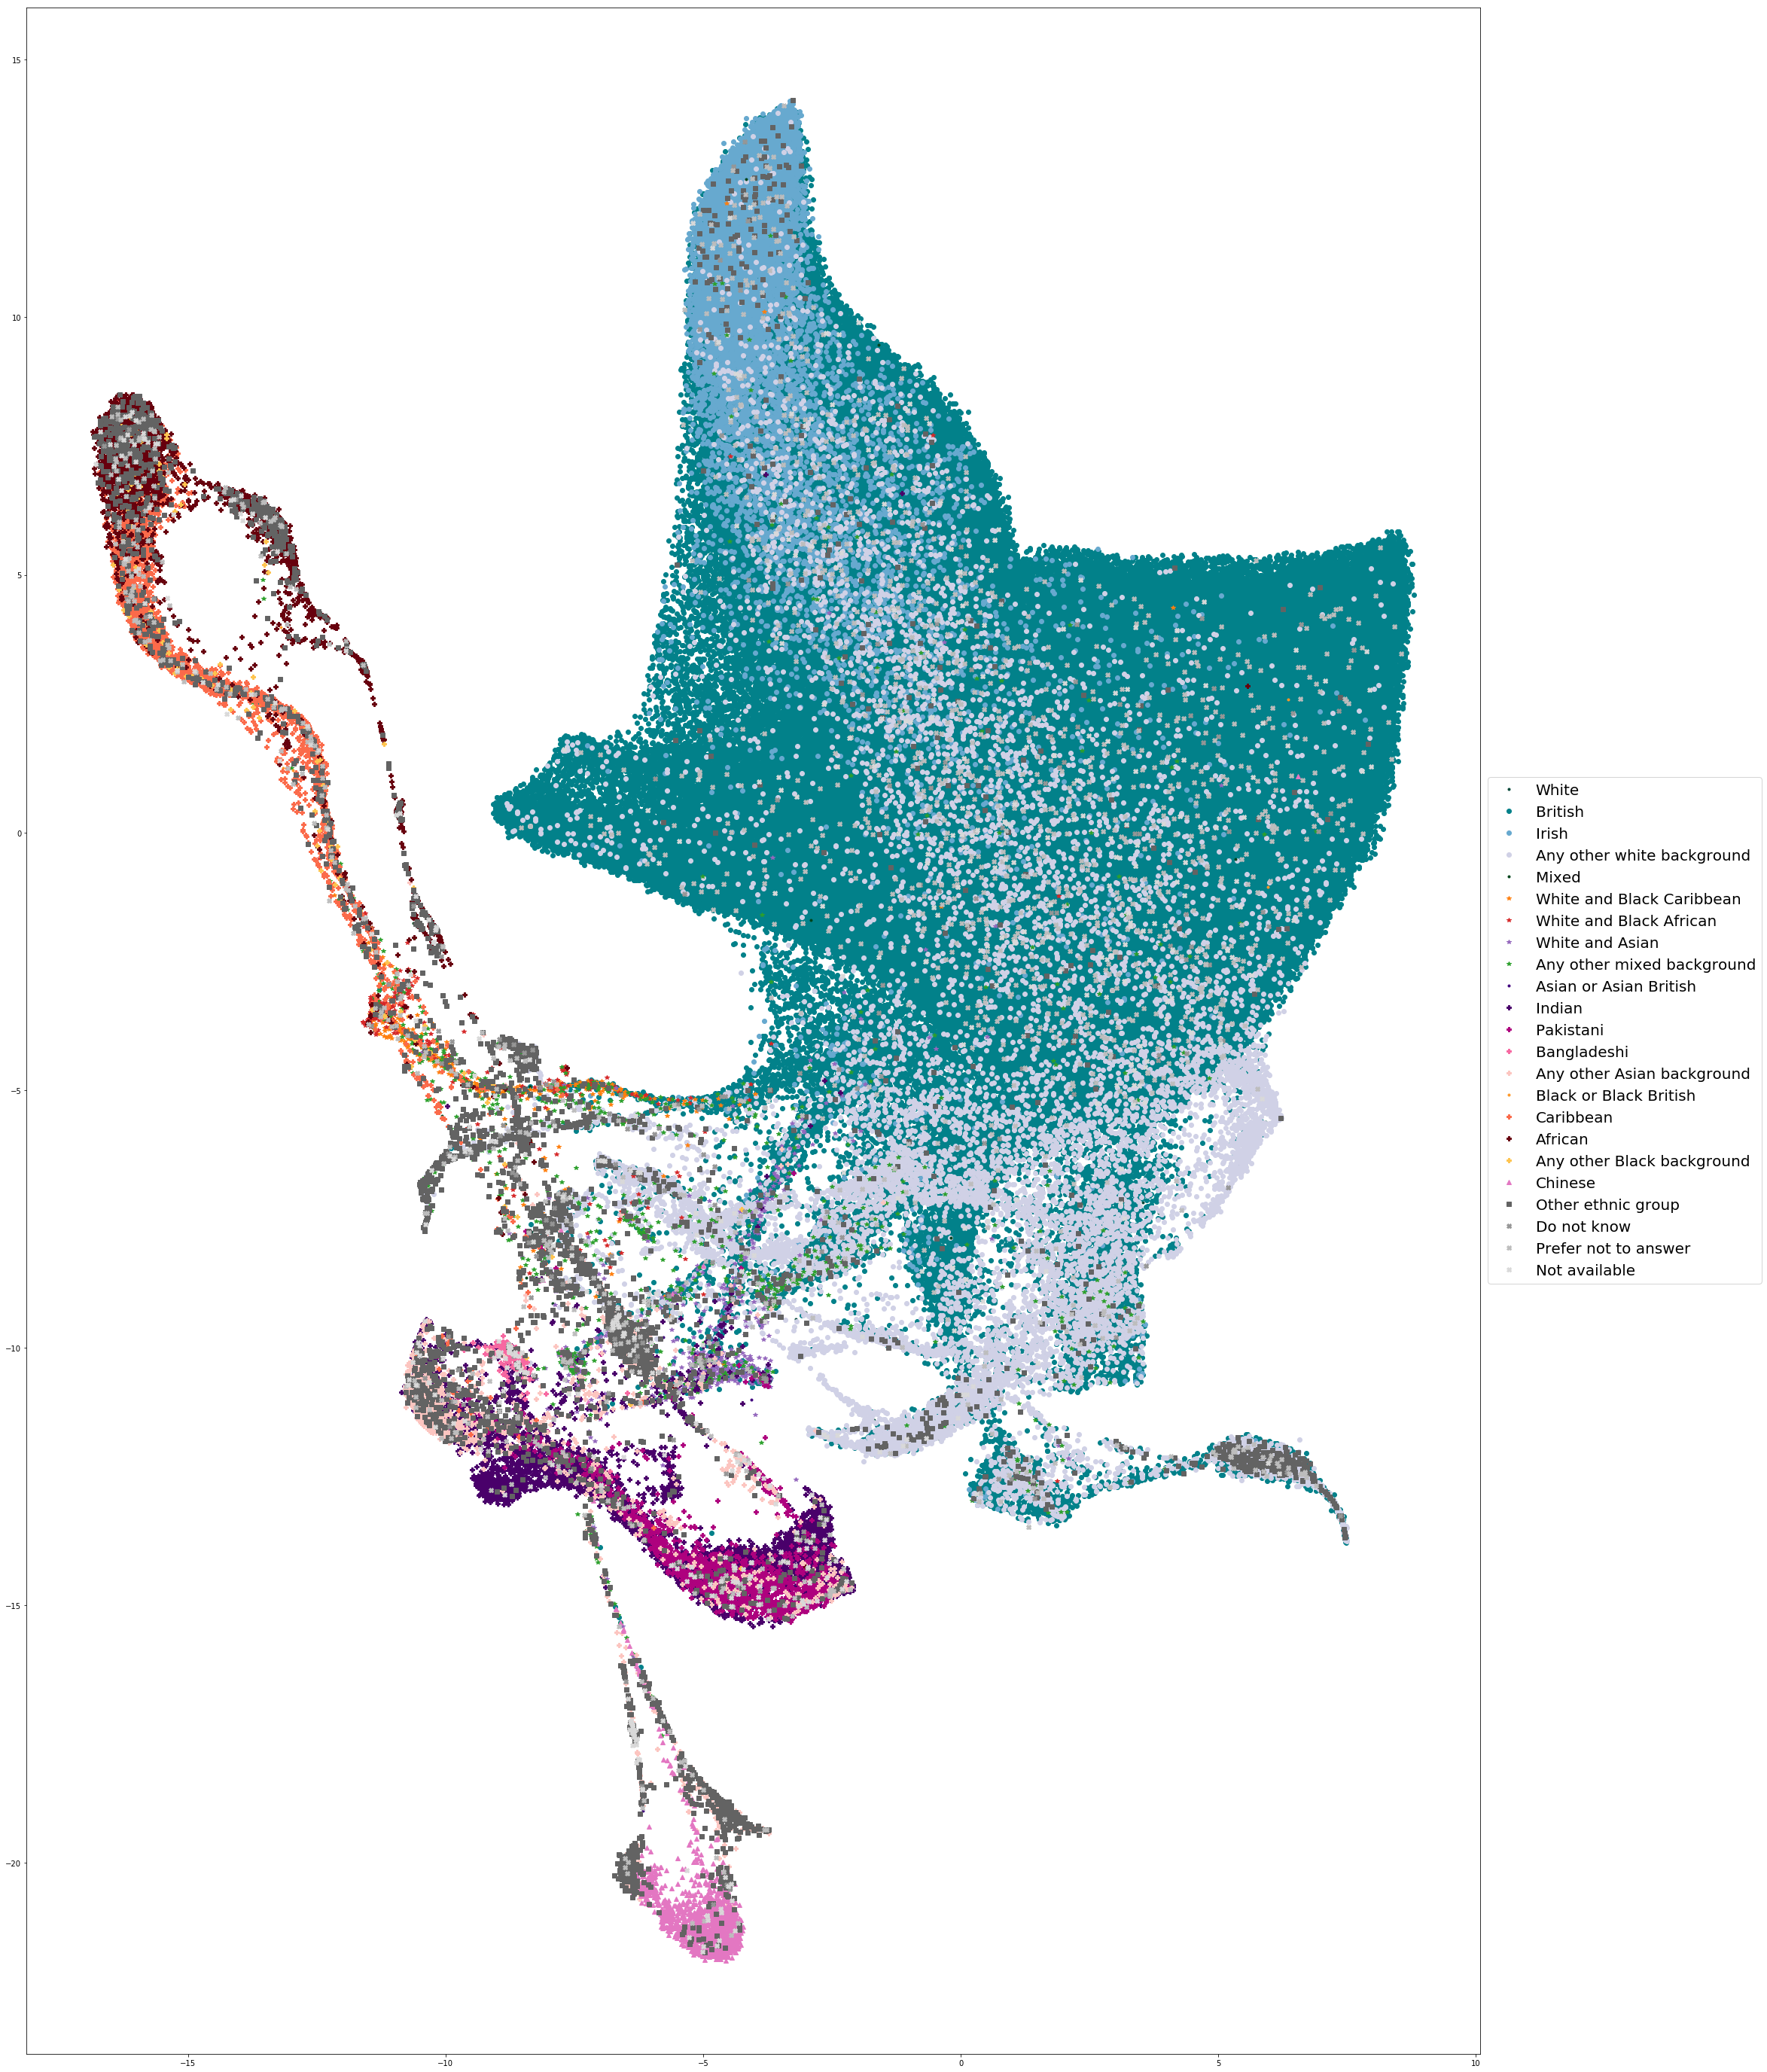

In [34]:
# Import a 2D projection and generate an image
proj_dir = '/Volumes/Stockage/alex/ukbb_projections'
proj_name = 'UKBB_UMAP_PC12_NC2_NN15_MD0.5_20184415956'
proj = np.loadtxt(os.path.join(proj_dir, proj_name))

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

for pop in ukbb_eth_dict_parent:
    if pop in ['White','Mixed','Asian or Asian British','Black or Black British']:
        temp_proj = proj[indices_of_population_members[pop],:]
        ax.plot(temp_proj[:,0], temp_proj[:,1],'.',label=pop,color=color_dict_ukbb[pop])

    for subpop in ukbb_eth_dict_parent[pop]:
        temp_proj = proj[indices_of_population_members[subpop],:]
        ax.plot(temp_proj[:,0], temp_proj[:,1],markers_dict[pop],label=subpop,color=color_dict_ukbb[subpop])

ax.legend(ncol=1,loc='center left', bbox_to_anchor=(1,0.5), fontsize=20)

This code is the same, but loops through and finds all 2D UMAP and tSNE projections and plots them (i.e. it does multiple plots rather than selecting one). This is based on my naming conventions entirely so YMMV.

In [42]:
proj_dir = '/Volumes/Stockage/alex/ukbb_projections'
out_dir = '/Volumes/Stockage/alex/ukbb_images'

# Loop through every file in specified directory
for fname in os.listdir(proj_dir):
    # Only plot UMAP and TSNE projections in 2D
    if 'UMAP' not in fname and 'TSNE' not in fname and 'tsne' not in fname and not 'NC3' in fname \
    or os.path.isdir(os.path.join(proj_dir,fname)):
        continue
    else:   
        # Don't overwrite existing plots
        if not os.path.exists(os.path.join(out_dir, fname+'_eth.jpeg')):
            print('Beginning plotting for ' + fname)
            
            proj = np.loadtxt(os.path.join(proj_dir, fname))
            fig = plt.figure(figsize=(50,50))
            ax = fig.add_subplot(111, aspect=1)

            for pop in ukbb_eth_dict_parent:
                if pop in ['White','Mixed','Asian or Asian British','Black or Black British']:
                    temp_proj = proj[indices_of_population_members[pop],:]
                    ax.scatter(temp_proj[:,0], temp_proj[:,1],label=pop,color=color_dict_ukbb[pop],alpha=0.6)

                for subpop in ukbb_eth_dict_parent[pop]:
                    temp_proj = proj[indices_of_population_members[subpop],:]
                    if subpop in ['Other ethnic group','Do not know']:
                        ax.scatter(temp_proj[:,0], temp_proj[:,1],marker=markers_dict[pop],label=subpop,facecolors='none',
                                edgecolors=color_dict_ukbb[subpop],alpha=0.6)
                    else:
                        ax.scatter(temp_proj[:,0], temp_proj[:,1],marker=markers_dict[pop],label=subpop,color=color_dict_ukbb[subpop],alpha=0.6)

            ax.legend(ncol=4,loc='lower center', bbox_to_anchor=(0.4,-0.12), fontsize=40,markerscale=10)

            fig.savefig(os.path.join(out_dir, fname+'_eth.jpeg'),format='jpeg')
            plt.close()

Beginning plotting for UKBB_UMAP_PC10_NC2_NN15_MD0.5_2018912173412
Beginning plotting for UKBB_UMAP_PC10_NC2_NN15_MD0.5_2018912201345
Beginning plotting for UKBB_UMAP_PC10_NC2_NN15_MD0.5_2018912234428
Beginning plotting for UKBB_UMAP_PC10_NC2_NN15_MD0.5_2018913224327
Beginning plotting for UKBB_UMAP_PC11_NC2_NN15_MD0.5_2018912174719
Beginning plotting for UKBB_UMAP_PC12_NC2_NN15_MD0.5_201891218031
Beginning plotting for UKBB_UMAP_PC13_NC2_NN15_MD0.5_2018912181334
Beginning plotting for UKBB_UMAP_PC14_NC2_NN15_MD0.5_2018912182641
Beginning plotting for UKBB_UMAP_PC15_NC2_NN15_MD0.5_201891220275
Beginning plotting for UKBB_UMAP_PC15_NC2_NN15_MD0.5_2018912235739
Beginning plotting for UKBB_UMAP_PC15_NC2_NN15_MD0.5_2018913225652
Beginning plotting for UKBB_UMAP_PC20_NC2_NN15_MD0.5_2018912204524
Beginning plotting for UKBB_UMAP_PC20_NC2_NN15_MD0.5_201891301530
Beginning plotting for UKBB_UMAP_PC20_NC2_NN15_MD0.5_2018913231251
Beginning plotting for UKBB_UMAP_PC25_NC2_NN15_MD0.5_201891221411

# Plotting (geography)

In [120]:
# Create some default values for easting and northing where it's missing
# The values themselves aren't used as missing data is plotted as transparent points
# We assign a value so it doesn't get binned or break the indexing later.
easting_mean = np.mean(easting_orig)
northing_mean = np.mean(northing_orig)

We need to do KD-tree nearest neighbour imputation.

Algorithm for KD stuff. For each point, grab the phenotype measurement from ones of its k nearest neighbours and just plot that.
1. Reduce dataset to observations that have data
2. Select point
3. Find neighbours
3. Randomly choose neighbour
5. Impute whatever value we're looking at (in the case of geography it's the geo coords/colourings)

In [121]:
# Import the projection and subset it to just those that have geographical data
proj_dir = '/Volumes/Stockage/alex/ukbb_projections'
file = 'UKBB_UMAP_PC10_NN15_MD0.5_2018328174511'

temp_proj = np.loadtxt(os.path.join(proj_dir,file))

# indices of points that have geographical coordinates
has_data = ukbb_df_joined2.loc[(np.isnan(ukbb_df_joined2.northing_orig)==False)].index

# Subset coordinate array such that it's only observations with data
temp_proj_geo = temp_proj[has_data]

# Make it into a dataframe and make a list of the coordinates, where they exist
has_data_df = ukbb_df_joined2.iloc[has_data]
has_data_coords = has_data_df[['northing_filled','easting_filled']].values.tolist()

In [122]:
# Create K-D tree object
kd_obj = scipy.spatial.KDTree(temp_proj_geo)

Variables:
* round_val (position to which we wish to round)
* sd (standard deviation, in metres, of the noise we add to each point)
* base (value to which we wish to round, e.g. nearest 10, nearest 25, in metres)

These will be reflected in the file name at the end.

In [123]:
# Test out permutations with nearest neighbours. We'll swap in values of randomly select neighbours.
# Those with zero values are invalid, so we make them invisible (alpha value of zero)
temp_colours_ns = []
temp_colours_ew = []

temp_alpha = []

ns_min = 100000
ns_max = 700000
ew_min = 200000
ew_max = 600000
alpha_vals = 0.6

round_val = -4
sd=50000
base=25000 # round to nearest however many thousand metres

for u in has_data_coords:
    no_geo = False
    # Set alpha to zero for unknown geo values
    if u[0]<=0 or u[1]<=0:
        no_geo = True
        temp_alpha.append(np.float(0))
        temp_colours_ns.append((northing_mean))
        temp_colours_ew.append((easting_mean))

    if no_geo==False:
        if u[0] < ns_min:
            temp_colours_ns.append(ns_min)
        elif u[0] > ns_max:
            temp_colours_ns.append(ns_max)
        else:
            temp_colours_ns.append(round(u[0] + np.random.normal(0,sd),round_val))
        
        if u[1] < ew_min:
            temp_colours_ew.append(ew_min)
        elif u[1] > ew_max:
            temp_colours_ew.append(ew_max)
        else:
            temp_colours_ew.append(round(u[1] + np.random.normal(0,sd),round_val))
                        
        temp_alpha.append(np.float(alpha_vals))

In [124]:
# Rounding for labels 
temp_colours_ns = [t/1000 for t in temp_colours_ns]
temp_colours_ew = [t/1000 for t in temp_colours_ew]

ns_min = ns_min/1000
ns_max = ns_max/1000
ew_min = ew_min/1000
ew_max = ew_max/1000

In [125]:
# Create a random seed and store it for reproducibility
np.random.seed(None)

In [126]:
st0 = np.random.get_state()

temp_colours_permuted_ns = []
temp_colours_permuted_ew = []
index_list = []

# Now that we have our colouring values we can sample them randomly (since neighbours exist now)
for t in range(0, temp_proj_geo.shape[0]):
    # Randomly select an index from a neighbour
    nn_index = np.random.choice(kd_obj.query(temp_proj_geo[t],10)[1][1:])
    index_list.append(nn_index)
    temp_colours_permuted_ns.append(temp_colours_ns[nn_index])
    temp_colours_permuted_ew.append(temp_colours_ew[nn_index])

In [127]:
norm_ns = matplotlib.colors.Normalize(vmin=ns_min, vmax=ns_max, clip=False)
norm_ew = matplotlib.colors.Normalize(vmin=ew_min, vmax=ew_max, clip=False)
mapper_ns = cm.ScalarMappable(norm=norm_ns, cmap=cm.coolwarm_r)
mapper_ew = cm.ScalarMappable(norm=norm_ew, cmap=cm.spring)

In [128]:
colours_ns = []
colours_ew = []
    
for i in range(0, temp_proj_geo.shape[0]):
    colours_ns.append(mapper_ns.to_rgba(temp_colours_permuted_ns[i], alpha=temp_alpha[i]))
    colours_ew.append(mapper_ew.to_rgba(temp_colours_permuted_ew[i], alpha=temp_alpha[i]))

In [129]:
# Not totally sure why I have to do this but here we are
mapper_ns_temp = mapper_ns
mapper_ew_temp = mapper_ew

mapper_ns_temp._A = []
mapper_ew_temp._A = []

In [130]:
# Create a timestamp to relate images to their random imputation
tstamp = ''.join([str(t) for t in time.gmtime()[0:6]])

proj_dir = '/Volumes/Stockage/alex/ukbb_projections'
img_dir = '/Volumes/Stockage/alex/ukbb_images/other/sandbox'
suffix = '_permuted_10nn_sd' + str(sd) + '_base' + str(base)
file = 'UKBB_UMAP_PC10_NN15_MD0.5_2018328174511'
fsize = 80 # font size
frot = 0 # rotation of ticks

temp_proj = temp_proj_geo
    
# North-South colouring
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_ns, cmap=cm.coolwarm_r, s=5)
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_ns_temp,orientation='horizontal',cax=cax)
cbar.set_label('Northing (km)',size=fsize)
cbar.ax.tick_params(labelsize=fsize, rotation=frot)
cbar.ax.text(s='More south',y=0.25, x=0.05, fontsize=fsize)
cbar.ax.text(s='More north',y=0.25, x=0.75, fontsize=fsize)

ax.axis('off')

fig.savefig(os.path.join(img_dir,file + '_ns' + suffix + '_' + tstamp + '.jpeg'),format='jpeg',bbox_inches='tight')
plt.close()

# East-West colouring
fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_ew, cmap=cm.spring, s=5)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_ew_temp,orientation='horizontal',cax=cax)
cbar.set_label('Easting (km)',size=fsize)
cbar.ax.tick_params(labelsize=fsize, rotation=frot)
cbar.ax.text(s='More west',y=0.25, x=0.05, fontsize=fsize)
cbar.ax.text(s='More east',y=0.25, x=0.75, fontsize=fsize)

ax.axis('off')

fig.savefig(os.path.join(img_dir,file + '_ew' + suffix + '_' + tstamp + '.jpeg'),format='jpeg',bbox_inches='tight')
plt.close()

with open(os.path.join(img_dir,'randomstate_' + tstamp + '.txt'), 'w') as f:
    f.write(str(st0))

# Plotting (phenotypes)
Basically the same as geographical colouring... but with phenotypes! The main difference is that since the colourings are relative to sex, we need two for each variable (one male, one female). Other than that, you just select the dataset that contains your variables, the caption you'd like, the rounding value, and the percentiles where you'll cut off the measurements. Percentiles are symmetric, so selecting 5 will give you everything between the 5th and 95th percentiles.

Filenames will have a timestamp. This is used to match the randomization state to the images generated, allowing for reproducibility.

In [153]:
dset = ukbb_pheno_joined_height_res_blood

# Values used for residual height
#plot_var = 'Height_res'
#caption = 'Age-adjusted residual height (cm)'

#percentile = 1
#round_val = 0

# Values used for FEV1
#plot_var = '3063_0_0'
#caption = 'FEV1'

#percentile = 1
#round_val = 1

# Values used for blood phenotypes

plot_var = 'neutrophill_count'
caption = 'Neutrophil count (10^9 cells/L)'

#plot_var = 'basophill_count'
#caption = 'Basophil count (10^9 cells/L)'

#plot_var = 'eosinophill_count'
#caption = 'Eosinophil count (10^9 cells/L)'

#plot_var = 'leukocyte_count'
#caption = 'Leukocyte count (10^9 cells/L)'

percentile = 5
round_val = 1
base_val = 0.2

In [154]:
# Get the indices of the sexes and create a dataset for each one
has_data_f = dset.loc[((np.isnan(dset[plot_var])==False) & (dset['sex']=='0'))].index
has_data_m = dset.loc[((np.isnan(dset[plot_var])==False) & (dset['sex']=='1'))].index

has_data_f_df = dset.iloc[has_data_f]
has_data_m_df = dset.iloc[has_data_m]

In [155]:
# Load the projection dataset and subset it
proj_dir = '/Volumes/Stockage/alex/ukbb_projections/'
fname = 'UKBB_UMAP_PC10_NN15_MD0.5_2018328174511'

temp_proj=np.loadtxt(os.path.join(proj_dir,fname))
temp_proj_f=temp_proj[has_data_f]
temp_proj_m=temp_proj[has_data_m]

In [156]:
# Generate the KD tree objects
kd_obj_f = scipy.spatial.KDTree(temp_proj_f)
kd_obj_m = scipy.spatial.KDTree(temp_proj_m)

temp_list_m = has_data_m_df[plot_var].values.tolist()#[t[0] for t in temp_list if t[1]=='1']
temp_list_f = has_data_f_df[plot_var].values.tolist()#[t[0] for t in temp_list if t[1]=='0']

females = has_data_f_df
males = has_data_m_df

dset_list_f = females[plot_var].values.tolist()
dset_list_m = males[plot_var].values.tolist()

dset_list_f = [round(d, round_val) for d in dset_list_f]
dset_list_m = [round(d, round_val) for d in dset_list_m]

min_m = np.nanpercentile(np.array(dset_list_m), percentile)
max_m = np.nanpercentile(np.array(dset_list_m), 100-percentile)
min_f = np.nanpercentile(np.array(dset_list_f), percentile)
max_f = np.nanpercentile(np.array(dset_list_f), 100-percentile)

num_bins_f = (max_f - min_f)/0.1 + 1
num_bins_m = (max_m - min_m)/0.1 + 1

alpha_vals = 0.6
print('Min (F): ' + str(min_f) + ', Min (F): ' + str(max_f) + ', Bins: ' + str(num_bins_f))
print('Min (M): ' + str(min_m) + ', Max (M): ' + str(max_m) + ', Bins: ' + str(num_bins_m))

Min (F): 3.6, Min (F): 9.9, Bins: 64.0
Min (M): 4.3, Max (M): 11.4, Bins: 72.0


In [157]:
# Create a random seed and store it for reproducibility
np.random.seed(None)
st0 = np.random.get_state()

# Initialize lists of colouring values
temp_colours_f = []
temp_colours_m = []
temp_colours_permuted_f = []
temp_colours_permuted_m = []
temp_alpha_f = []
temp_alpha_m = []

# Prepare the colouring (females)
for h in dset_list_f:
    # Unknown value - make it transparent and add an arbitrary value
    if np.isnan(h):
        temp_colours_f.append(np.mean([min_f, max_f]))
        temp_alpha_f.append(0)
    elif h < min_f:
        temp_colours_f.append(min_f)
        temp_alpha_f.append(alpha_vals)
    elif h > max_f:
        temp_colours_f.append(max_f)
        temp_alpha_f.append(alpha_vals)
    else:
        temp_colours_f.append(h)
        temp_alpha_f.append(alpha_vals)
        
# Permute the colouring (females)
for t in range(0, temp_proj_f.shape[0]):
    nn_index = np.random.choice(kd_obj_f.query(temp_proj_f[t],10)[1][1:])
    temp_colours_permuted_f.append(temp_colours_f[nn_index])
    
norm_f = matplotlib.colors.Normalize(vmin=min_f, vmax=max_f, clip=False)
mapper_f = cm.ScalarMappable(norm=norm_f, cmap=cm.coolwarm)

colours_f = []
    
for i in range(0, len(temp_colours_f)):
    colours_f.append(mapper_f.to_rgba(temp_colours_permuted_f[i], alpha=temp_alpha_f[i]))
    
mapper_f_temp = mapper_f
mapper_f_temp._A = []

# Prepare the colouring (males)
for h in dset_list_m:
    # Unknown value - make it transparent and add an arbitrary value
    if np.isnan(h):
        temp_colours_m.append(np.mean([min_m, max_m]))
        temp_alpha_m.append(0)
    elif h < min_m:
        temp_colours_m.append(min_m)
        temp_alpha_m.append(alpha_vals)
    elif h > max_m:
        temp_colours_m.append(max_m)
        temp_alpha_m.append(alpha_vals)
    else:
        temp_colours_m.append(h)
        temp_alpha_m.append(alpha_vals)

# Permute the colouring (males)
for t in range(0, temp_proj_m.shape[0]):
    nn_index = np.random.choice(kd_obj_m.query(temp_proj_m[t],10)[1][1:])
    temp_colours_permuted_m.append(temp_colours_m[nn_index])
        
norm_m = matplotlib.colors.Normalize(vmin=min_m, vmax=max_m, clip=False)
mapper_m = cm.ScalarMappable(norm=norm_m, cmap=cm.coolwarm)

colours_m = []
    
for i in range(0, len(temp_colours_m)):
    colours_m.append(mapper_m.to_rgba(temp_colours_permuted_m[i], alpha=temp_alpha_m[i]))
    
mapper_m_temp = mapper_m
mapper_m_temp._A = []

In [158]:
tstamp = ''.join([str(t) for t in time.gmtime()[0:6]])

out_dir = '/Volumes/Stockage/alex/ukbb_images/other/sandbox'
fname = 'UKBB_UMAP_PC10_NN15_MD0.5_2018328174511_' + tstamp
size = 20
fsize = 80 #font size

# Female phenotypes
temp_proj = temp_proj_f

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_f, cmap=cm.coolwarm, s=size)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_f_temp,orientation='horizontal',cax=cax)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(caption,size=fsize)

ax.axis('off')

fig.savefig(os.path.join(out_dir, fname.replace('.','')+'_'+plot_var+'_pct'+str(percentile)+'_f.jpeg'),format='jpeg',
           bbox_inches='tight')
plt.close()

# Male phenotypes
#temp_proj = proj[indices_of_population_sex['1']]
temp_proj = temp_proj_m

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(111, aspect=1)

ax.scatter(temp_proj[:,0], temp_proj[:,1], c=colours_m, cmap=cm.coolwarm, s=size)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom',size='5%',pad=0.05)

cbar = plt.colorbar(mapper_m_temp,orientation='horizontal',cax=cax)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(caption,size=fsize)

ax.axis('off')

fig.savefig(os.path.join(out_dir, fname.replace('.','')+'_'+plot_var+'_pct'+str(percentile)+'_m.jpeg'),format='jpeg',
           bbox_inches='tight')
plt.close()

with open(os.path.join(out_dir,'randomstate_' + tstamp + '.txt'), 'w') as f:
    f.write(str(st0))

# Boxplots
The boxplots are straightforward - the only changes are basically in formatting, axes, and labelling for each sex and variable. P-values are from comparisons between the White British ethnic group and others, with a Bonferroni correction for 12 comparisons.

In [141]:
# The order the boxes will appear.
order_list = ['British','Irish','Any other white background','White and Black African','White and Black Caribbean',
                     'White and Asian','African','Caribbean','Any other Black background',
                     'Chinese','Indian','Pakistani','Bangladeshi']

In [142]:
# List of the variables for which we'll create boxplots
var_list = ['Height_res','3063_0_0','neutrophill_count','basophill_count','eosinophill_count','leukocyte_count']

In [208]:
# Captions/labels
label_dict = {'Height_res':'Age-adjusted residual height (cm)',
              '3063_0_0':'FEV1',
              'neutrophill_count':'Neutrophil count (10^9 cells/L)',
              'basophill_count':'Basophil count (10^9 cells/L)',
              'eosinophill_count':'Eosinophil count (10^9 cells/L)',
              'leukocyte_count':'Leukocyte count (10^9 cells/L)'}
# Plot titles
title_dict = {'Height_res':'Residual height',
              '3063_0_0':'FEV1',
              'neutrophill_count':'Neutrophil count',
              'basophill_count':'Basophil count',
              'eosinophill_count':'Eosinophil count',
              'leukocyte_count':'Leukocyte count'}
# Offsets used for labelling p-values
xy_dict = {'Height_res':{'F':19.9,'M':19.9},
          '3063_0_0':{'F':4,'M':5.5},
          'neutrophill_count':{'F':12.2,'M':13},
          'basophill_count':{'F':8.2,'M':8.2},
          'eosinophill_count':{'F':4.2,'M':4},
          'leukocyte_count':{'F':12.2,'M':12.2}}
# Ranges for the x-axis of the boxplots
xlim_dict = {'Height_res':{'F':[-25,30.2],'M':[-25,30.2]},
             '3063_0_0':{'F':[0,5],'M':[0,6.8]},
             'neutrophill_count':{'F':[0,15],'M':[0,15.7]},
             'basophill_count':{'F':[0,10],'M':[0,10]},
             'eosinophill_count':{'F':[0,5.1],'M':[0,4.8]},
             'leukocyte_count':{'F':[0,15],'M':[0,15]}}
# Full word for sex (instead of M/F)
sex_dict = {'F':'Female', 'M':'Male'}
# Translate between 0/F and 1/M
sex_dict_code = {'F':'0', 'M':'1'}

In [180]:
# Use the dataset with text labels for ethnicity
dset = ukbb_pheno_joined_height_res_blood_2

In [212]:
# Set the output directory
img_dir = '/Volumes/Stockage/alex/ukbb_images/other/sandbox'

# This double loop goes through every variable for each sex
for v in var_list:
    for sex in ['F','M']:
        # First calculate the p-values relative to the British population, with a Bonferroni correction
        set1 = dset.loc[((dset['eth_txt']=='British') & (dset['sex']==sex_dict_code[sex]))]
        pv_list = list()

        # For each non-British ethnicity, compare the differences and retrieve the p-value
        for eth in eth_list[1:]:
            set2 = dset.loc[((dset['eth_txt']==eth) & (dset['sex']==sex_dict_code[sex]))]
            pv_list.append(format(ttest_ind(set1[v], set2[v], nan_policy='omit').pvalue,'.2e'))

        # From here we're just creating and formatting the boxplot
        fsize=30
        fig, ax = plt.subplots(figsize=(30,20))
        sns.boxplot(ax = ax, orient='h',
                    palette = color_dict_ukbb,
                    y = 'eth_txt',
                    x = v,
                    showfliers=False,
                    order = order_list,
                   data = dset.loc[(dset['sex']==sex_dict_code[sex])])

        # Annotate with p-values
        for pv in range(0,len(pv_list)):
            if np.float(pv_list[pv])<0.05/12:
                ax.annotate(s='* (p-val: '+pv_list[pv]+')',xy=(xy_dict[v][sex],pv+1),size=30)
            else:
                ax.annotate(s='  (pval: ' + pv_list[pv]+')',xy=(xy_dict[v][sex],pv+1),size=30)

        # Axis limits, labels
        ax.set_xlim(xlim_dict[v][sex])        
        ax.set_xlabel(label_dict[v])
        ax.set_ylabel('Ethnic background')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
        ax.set_title(title_dict[v] + ' by ethnic background (' + sex_dict[sex] + ')')

        # Font sizes
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                      ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(30)

        # Specify a filename giving the variable and sex, and save
        fname = 'boxplot_' + v + '_' + sex
        fig.savefig(os.path.join(img_dir,fname + '.jpeg'),format='jpeg',bbox_inches='tight')
        plt.close()

        print('Created boxplot for ' + title_dict[v] + ' for ' + sex_dict[sex])

Created boxplot for Residual height for Female
Created boxplot for Residual height for Male
Created boxplot for FEV1 for Female
Created boxplot for FEV1 for Male
Created boxplot for Neutrophil count for Female
Created boxplot for Neutrophil count for Male
Created boxplot for Basophil count for Female
Created boxplot for Basophil count for Male
Created boxplot for Eosinophil count for Female
Created boxplot for Eosinophil count for Male
Created boxplot for Leukocyte count for Female
Created boxplot for Leukocyte count for Male
